In [1]:
import sys
import glob
import os
import re
import json
import itertools
import bisect
import functools
import scipy
import math
import random
from collections import defaultdict

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from PIL import Image
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import average_precision_score, PrecisionRecallDisplay, precision_recall_curve, balanced_accuracy_score


In [2]:
mpl.rcParams['figure.figsize'] = (14,14)
FONT_SIZE = 24
plt.rc('font', size=FONT_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=FONT_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=FONT_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=FONT_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=FONT_SIZE)    # legend fontsize
plt.rc('figure', titlesize=FONT_SIZE)  # fontsize of the figure title

plt.rc('figure', max_open_warning=50)

In [3]:
def get_pvalue_mapping(values):
    sz = len(values)
    return [(val, (sz-idx)/sz) for idx, val in enumerate(sorted(values))]

def get_pvalue(mapping, val):
    idx = bisect.bisect_left(mapping, (val, -1))
    if idx == 0:
        return 1.0
    else:
        return mapping[idx-1][1]

def get_datatype(dataset):
    return dataset.split(':')[0]

def get_experiment_id(dataset):
    return dataset.split(':')[1]


def load_dataset_correlations(heatmaps_glob):
    dataset_correlation_triples = []
    for dataset_correlation_heatmap_fn in glob.glob(heatmaps_glob):
        tf = re.sub(r'\.json$', '', os.path.basename(dataset_correlation_heatmap_fn))
        with open(dataset_correlation_heatmap_fn) as f:
            data = json.load(f)['data']
        #
        for ds_info in data:
            ds_1 = ds_info['name']
            for corr_info in ds_info['data']:
                ds_2 = corr_info['x']
                val = corr_info['y']
                if ds_1 < ds_2:
                    dataset_correlation_triples.append((ds_1, ds_2, val))
    return dataset_correlation_triples

def collect_pvalue_mappings(dataset_correlation_triples):
    datatypes_1 = []
    datatypes_2 = []
    values = []
    for ds_1, ds_2, val in dataset_correlation_triples:
        dt_1, dt_2 = get_datatype(ds_1), get_datatype(ds_2)
        datatypes_1.append(dt_1)
        datatypes_2.append(dt_2)
        values.append(val)
        if dt_1 != dt_2:
            datatypes_1.append(dt_2)
            datatypes_2.append(dt_1)
            values.append(val)
    #
    df = pd.DataFrame({
        'datatype_1': datatypes_1,
        'datatype_2': datatypes_2,
        'value': values,
    })
    #
    pvalue_mappings = defaultdict(dict)
    for dt1 in DATA_TYPES:
        for dt2 in DATA_TYPES:
            vals = list(df[(df.datatype_1 == dt1) & (df.datatype_2 == dt2)]['value'])
            pvalue_mappings[dt1][dt2] = get_pvalue_mapping(vals)
    return pvalue_mappings

def collect_pvalue_lists_by_dataset_and_datatype(dataset_correlation_triples):
    pvalue_mappings = collect_pvalue_mappings(dataset_correlation_triples)
    dataset_pvalues = defaultdict(lambda: defaultdict(list))
    for (ds_1, ds_2, val) in dataset_correlation_triples:
        # try:
        dt_1, dt_2 = get_datatype(ds_1), get_datatype(ds_2)
        pvalue = get_pvalue(pvalue_mappings[dt_1][dt_2], val)
        dataset_pvalues[ds_1][dt_2].append(pvalue)
        dataset_pvalues[ds_2][dt_1].append(pvalue)
        # except:
        #     print(ds_1, ds_2)
        #     print(dataset_pvalues.keys())
        #     print(dt_1, dt_2)
        #     print(pvalue_mappings.keys())
        #     raise
    return dataset_pvalues


def logpval(pvalue):
    if pvalue:
        return -math.log10(pvalue)
    else:
        return None

def aggregate_pvalues(pvalues, aggregation_method):
    if len(pvalues) == 0:
        return None
    #
    if aggregation_method == 'min':
        return min(pvalues)
    elif aggregation_method == 'fisher':
        _, agg_pval = scipy.stats.combine_pvalues(pvalues, method='fisher')
        return agg_pval
    elif aggregation_method == 'tippett':
        _, agg_pval = scipy.stats.combine_pvalues(pvalues, method='tippett')
        return agg_pval
    elif aggregation_method == 'mudholkar-george':
        filtered_pvalues = [pval for pval in pvalues if pval != 1.0]
        if len(filtered_pvalues) == 0:
            return min(pvalues)
        _, agg_pval = scipy.stats.combine_pvalues(filtered_pvalues, method='mudholkar_george')
        return agg_pval
    elif aggregation_method == 'mudholkar-george-filtered':
        small_pvalues = [pval for pval in pvalues if pval < 0.5]
        if len(small_pvalues) == 0:
            return min(pvalues)
        _, agg_pval = scipy.stats.combine_pvalues(small_pvalues, method='mudholkar_george')
        return agg_pval
    else:
        raise Exception(f'Unknown aggregation method `{aggregation_method}`')


In [4]:
def collect_aggregated_pvalues(pvalue_lists_by_dataset_and_datatype, aggregation_methods=None):
    datasets = []
    tfs = []
    experiment_types = []
    aggregated_pvalues = defaultdict(list)
    datatype_counts = defaultdict(list)
    is_curated = []
    # is_artifact = []
    artifact_metrics_min_quantile = defaultdict(list)
    artifact_metrics_num_in_q25 = defaultdict(list)
    best_artifact_types = []
    for dataset in pvalue_lists_by_dataset_and_datatype:
        intra_datatype = get_datatype(dataset)
        exp_id = get_experiment_id(dataset)
        tf = tf_by_expname[exp_id]
        #
        datasets.append(dataset.split(':')[1])
        tfs.append(tf)
        experiment_types.append(intra_datatype)
        #
        for datatype in DATA_TYPES:
            pvalues = pvalue_lists_by_dataset_and_datatype[dataset].get(datatype, [])
            datatype_counts[datatype].append( len(pvalues) )
            for aggregation_method in aggregation_methods:
                aggregated_pvalues[f'{datatype}_{aggregation_method}'].append( logpval(aggregate_pvalues(pvalues, aggregation_method)) )
        #
        intra_pvalues = pvalue_lists_by_dataset_and_datatype[dataset].get(intra_datatype, [])
        inter_pvalues = []
        for dt, pvals in pvalue_lists_by_dataset_and_datatype[dataset].items():
            if dt != intra_datatype:
                inter_pvalues += pvals
        #
        datatype_counts['intra'].append( len(intra_pvalues) )
        datatype_counts['inter'].append( len(inter_pvalues) )
        datatype_counts['all'].append( len(intra_pvalues + inter_pvalues) )
        for aggregation_method in aggregation_methods:
            aggregated_pvalues[f'intra_{aggregation_method}'].append( logpval(aggregate_pvalues(intra_pvalues, aggregation_method)) )
            aggregated_pvalues[f'inter_{aggregation_method}'].append( logpval(aggregate_pvalues(inter_pvalues, aggregation_method)) )
            aggregated_pvalues[f'all_{aggregation_method}'].append( logpval(aggregate_pvalues(intra_pvalues + inter_pvalues, aggregation_method)) )
        #
        is_curated.append('Curated'  if exp_id in good_datasets else 'Non-curated')
        # is_artifact.append('Artifact'  if exp_id in artifact_datasets else 'Non-artifact')
        best_artifact_type = 'None'
        best_artifact_quantile = 2.0
        for artifact_type in artifact_types:
            if exp_id in dataset_artifact_metrics_min_quantile:
                quantile = dataset_artifact_metrics_min_quantile[exp_id].get(artifact_type, 2.0)
            else:
                quantile = 2.0
            artifact_metrics_min_quantile[artifact_type].append(quantile)
            if quantile < best_artifact_quantile:
                best_artifact_type = artifact_type
                best_artifact_quantile = quantile
        best_artifact_types.append(best_artifact_type  if best_artifact_quantile <= ARTIFACT_QUANTILE_THRESHOLD  else 'None')
        #
        for artifact_type in artifact_types:
            if exp_id in dataset_artifact_metrics_num_in_q25:
                num_in_q25 = dataset_artifact_metrics_num_in_q25[exp_id].get(artifact_type, 0)
            else:
                num_in_q25 = 0
            artifact_metrics_num_in_q25[artifact_type].append(num_in_q25)
    #
    df = pd.DataFrame({
       'tf': tfs, 'experiment_type': experiment_types, 'dataset': datasets,
       'is_curated': is_curated, #'is_artifact': is_artifact,
       'artifact_type': best_artifact_types,
    })
    #
    for dt in ['all', 'inter', 'intra', *DATA_TYPES]:
        df[f'{dt}_count'] = datatype_counts[dt]
        for aggregation_method in aggregation_methods:
            df[f'{dt}_{aggregation_method}_logpval'] = aggregated_pvalues[f'{dt}_{aggregation_method}']
    #
    for artifact_type in artifact_types:
        df[f'{artifact_type}_quantile'] = artifact_metrics_min_quantile[artifact_type]
        df[f'{artifact_type}_num_in_q25'] = artifact_metrics_num_in_q25[artifact_type]
    #
    return df


In [5]:
def make_violinplot(df, filename, aggregation_method):
    df_intra = pd.DataFrame({'kind': 'intra', 'logpvalue': df[f'intra_{aggregation_method}_logpval'], 'dataset': df.dataset, 'is_curated': df.is_curated}) #, 'is_artifact': df.is_artifact})
    df_inter = pd.DataFrame({'kind': 'inter', 'logpvalue': df[f'inter_{aggregation_method}_logpval'], 'dataset': df.dataset, 'is_curated': df.is_curated}) #, 'is_artifact': df.is_artifact})
    df_by_kind = pd.concat([df_intra, df_inter]).dropna(subset=['logpvalue'])
    plt.figure()
    sns.violinplot(x='kind', hue='is_curated', hue_order=['Non-curated', 'Curated'], y='logpvalue', data=df_by_kind)
    plt.savefig(filename)
    plt.close()

###########

def make_scatterplot(df, filename, aggregation_method, max_logpval=float('inf')):
    plt.figure()
    bounded_df = df[(df[f'inter_{aggregation_method}_logpval'] <= max_logpval) & (df[f'intra_{aggregation_method}_logpval'] <= max_logpval)]
    # sns.scatterplot(x=f'intra_{aggregation_method}_logpval', y=f'inter_{aggregation_method}_logpval', hue='is_curated', hue_order=['Non-curated', 'Curated'], alpha=1.0, data=bounded_df[bounded_df.artifact_type != 'None'])
    sns.scatterplot(x=f'intra_{aggregation_method}_logpval', y=f'inter_{aggregation_method}_logpval', hue='is_curated', hue_order=['Non-curated', 'Curated'], alpha=1.0, data=bounded_df)
    # sns.scatterplot(x='intra_logpval', y='inter_logpval', hue='is_artifact', hue_order=['Non-artifact', 'Artifact'], alpha=1.0, data=bounded_df)
    # plt.xlim(0, 13)
    # plt.ylim(0, 13)
    plt.savefig(filename)
    plt.close()


In [6]:
def classifier_name(feature_list):
    clf_name = feature_list if isinstance(feature_list, str) else "+".join(feature_list)
    clf_name = clf_name.replace('/', '-')
    if len(clf_name) > 200:
        clf_name = "+".join(f'{ftr[:5]}..{ftr[-5:]}' for ftr in feature_list)
    return clf_name


In [7]:

def prediction_rates_by_recall(labels, predictions, recall_thresholds):
    num_positives = sum(labels)
    for recall_threshold in recall_thresholds:
        num_positives_recalled = 0
        for idx, (score,label) in enumerate(sorted(zip(predictions, labels), reverse=True), start = 1):
            num_positives_recalled += label
            if num_positives_recalled >= recall_threshold * num_positives:
                num_negatives = len(labels) - num_positives
                num_negatives_recalled = idx - num_positives_recalled
                yield (recall_threshold, score, (num_positives_recalled, num_positives), (num_negatives_recalled, num_negatives))
                break

def precision_by_recall(labels, predictions, recall_thresholds):
    if len(labels) != len(predictions):
        raise 'Labels and predictions are of inconsistent length'
    if len(predictions) == 0:
        raise 'Empty predictions'
    precision, recall, thresholds = precision_recall_curve(labels, predictions)
    precision, recall, thresholds = precision[::-1], recall[::-1], thresholds[::-1]
    for recall_threshold in recall_thresholds:
        idx = bisect.bisect_left(recall, recall_threshold)
        if idx != len(recall):
            yield (recall[idx], precision[idx], thresholds[idx])
        else:
            yield (recall[idx - 1], precision[idx - 1], thresholds[idx])


def positive_negative_curve(labels, predictions):
    num_positives = sum(labels)
    num_negatives = len(labels) - num_positives
    num_positives_recalled = 0
    for idx, (score,label) in enumerate(sorted(zip(predictions, labels), reverse=True), start = 1):
        num_positives_recalled += label
        num_negatives_recalled = idx - num_positives_recalled
        yield (score, (num_positives_recalled, num_positives), (num_negatives_recalled, num_negatives))

In [8]:
# heatmap_type_name = 'kendalTauB'
# heatmap_type_name = 'weightedTau'
# heatmap_type_name = 'weightedTau+cross-PBM'

# # Neither artifacts nor flanks are dropped
# heatmap_type_name = 'weightedTau+cross-PBM+allowMotifInFlanks'
# dataset_artifact_metrics_min_quantile_fn = 'dataset_artifact_metrics_min_quantile_crosspbm_noflanks.json'
# dataset_artifact_metrics_num_in_q25_fn = 'dataset_artifact_metrics_num_in_q25_crosspbm_noflanks.json'

# Both artifacts and flanks are prefiltered
heatmap_type_name = 'weightedTau+cross-PBM+dropped-artifacts_no-afs-reads/'
dataset_artifact_metrics_min_quantile_fn = 'dataset_artifact_metrics_min_quantile_crosspbm_allow-artifact_no-afs-reads.json'
dataset_artifact_metrics_num_in_q25_fn = 'dataset_artifact_metrics_num_in_q25_crosspbm_allow-artifact_no-afs-reads.json'

results_folder = f'./dataset_{heatmap_type_name}/' # sys.argv[1]
heatmaps_folder = f'./heatmaps_{heatmap_type_name}/' # sys.argv[2]

os.makedirs(results_folder, exist_ok=True)

DATA_TYPES = ['PBM', 'CHS', 'SMS', 'AFS-LYS', 'AFS-IVT', 'AFS-GFPIVT', 'HTS-LYS', 'HTS-IVT', 'HTS-GFPIVT']
AGGREGATION_METHODS = ['min', 'fisher', 'mudholkar-george', 'mudholkar-george-filtered', 'tippett']

ARTIFACT_QUANTILE_THRESHOLD = 0.05

In [9]:
with open(dataset_artifact_metrics_min_quantile_fn) as f:
    dataset_artifact_metrics_min_quantile = json.load(f)
with open(dataset_artifact_metrics_num_in_q25_fn) as f:
    dataset_artifact_metrics_num_in_q25 = json.load(f)

artifact_types = set()
for art_hsh in dataset_artifact_metrics_min_quantile.values():
    for artifact_type in art_hsh.keys():
        artifact_types.add(artifact_type)

artifact_types = sorted(artifact_types)

with open('good_datasets.txt') as f:
    good_datasets = set(l.strip() for l in f.readlines())


metadata = []
with open('metadata_release_8d.json') as f:
    for line in f:
        metadata.append(json.loads(line))

tf_by_expname = {}
for info in metadata:
    exp = info['experiment_id']
    replica = info.get('experiment_params', {}).get('replica')
    if replica:
        exp = f'{exp}.Rep-{replica}'
    tf = info['tf']
    if (exp in tf_by_expname) and tf_by_expname[exp] != tf:
        raise Exception('Error')
    tf_by_expname[exp] = tf

dataset_correlation_triples = load_dataset_correlations(f'{heatmaps_folder}/*.json')
pvalue_lists_by_dataset_and_datatype = collect_pvalue_lists_by_dataset_and_datatype(dataset_correlation_triples)


In [10]:
df = collect_aggregated_pvalues(pvalue_lists_by_dataset_and_datatype, AGGREGATION_METHODS)

In [11]:
# dataset_artifact_metrics_num_in_q25
# heatmaps_folder
df

,tf,experiment_type,dataset,is_curated,artifact_type,all_count,all_min_logpval,all_fisher_logpval,all_mudholkar-george_logpval,all_mudholkar-george-filtered_logpval,...,Artifact-07_GACA/GAC_quantile,Artifact-07_GACA/GAC_num_in_q25,Artifact-08_SP/KLF-endogenous-TFs_quantile,Artifact-08_SP/KLF-endogenous-TFs_num_in_q25,Artifact-09_ETS-endogenous-TFs_quantile,Artifact-09_ETS-endogenous-TFs_num_in_q25,Artifact-10_NucReceptor-endogenous-TFs_quantile,Artifact-10_NucReceptor-endogenous-TFs_num_in_q25,Artifact-11_In-Flank_quantile,Artifact-11_In-Flank_num_in_q25
0,ZNF536,AFS-GFPIVT,YWR_B_AffSeq_A10_ZNF536-DBD1,Non-curated,Artifact-04_CAC-repeat,15,0.621533,0.128517,0.386731,0.861631,...,2.0,0,0.709375,0,2.0,0,2.0,0,0.525000,0
1,ZNF536,AFS-GFPIVT,YWR_B_AffSeq_B10_ZNF536-DBD2,Non-curated,None,15,0.996994,0.151729,0.056714,1.838151,...,2.0,0,0.856250,0,2.0,0,2.0,0,0.425000,0
2,ZNF536,AFS-IVT,YWI_B_AffSeq_G01_ZNF536_DBD_1,Non-curated,Artifact-04_CAC-repeat,15,0.295121,0.000006,0.000069,0.295121,...,2.0,0,0.218750,1,2.0,0,2.0,0,0.203125,1
3,ZNF536,AFS-IVT,YWI_B_AffSeq_H01_ZNF536_DBD_2,Curated,None,15,1.050693,0.282708,0.410688,1.444000,...,2.0,0,0.581250,0,2.0,0,2.0,0,0.528125,0
4,ZNF536,AFS-LYS,YWK_B_AffSeq_C10_ZNF536,Non-curated,Artifact-04_CAC-repeat,15,0.295121,0.000707,0.014477,0.295121,...,2.0,0,0.296875,0,2.0,0,2.0,0,0.293750,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4232,ZNF699,HTS-GFPIVT,YWS_A_CA40NCATGTC,Non-curated,None,9,0.634429,0.213979,0.475461,0.666602,...,2.0,0,2.000000,0,2.0,0,2.0,0,0.175926,4
4233,ZNF699,HTS-GFPIVT,YWS_A_CT40NCGGAGA,Non-curated,Artifact-02_GGAGGG,9,0.701311,0.170755,0.320831,0.826888,...,2.0,0,2.000000,0,2.0,0,2.0,0,0.078704,4
4234,ZNF699,HTS-IVT,YWE_A_GT40NGGCATT,Non-curated,Artifact-01_ACGACG_Putative-self-annealing,9,0.794720,0.185159,0.340669,0.826806,...,2.0,0,2.000000,0,2.0,0,2.0,0,0.041667,3
4235,ZNF699,HTS-LYS,YWL_A_TC40NTAAGTG,Non-curated,Artifact-01_ACGACG_Putative-self-annealing,9,0.701311,0.046165,0.122994,0.526938,...,2.0,0,2.000000,0,2.0,0,2.0,0,0.004630,4


In [12]:
def recall_for_feature(df, feature):
    curated_num, other_num = 0, 0
    curated_ppr_indexed, other_ppr_indexed = [], []
    curated_total = sum(df['is_curated'] == 'Curated')
    other_total = sum(df['is_curated'] == 'Non-curated')
    for score, idx, curated in sorted( list(zip(df[feature], df.index, df['is_curated'] == 'Curated') ), reverse=True ):
        if curated:
            curated_num += 1
        else:
            other_num += 1
        curated_ppr_indexed.append((idx, curated_num / curated_total))
        other_ppr_indexed.append((idx, other_num / other_total))
    curated_ppr = [val for idx, val in sorted(curated_ppr_indexed)]
    other_ppr = [val for idx, val in sorted(other_ppr_indexed)]
    return curated_ppr, other_ppr

df['recall-curated@all_fisher_logpval'], df['recall-other@all_fisher_logpval'] = recall_for_feature(df, 'all_fisher_logpval')
df['recall-curated@all_mudholkar-george_logpval'], df['recall-other@all_mudholkar-george_logpval'] = recall_for_feature(df, 'all_mudholkar-george_logpval')
df_short = df[
    ['tf', 'experiment_type', 'dataset', 'is_curated', 'artifact_type',
    'all_fisher_logpval', 'all_mudholkar-george_logpval',
     'recall-curated@all_fisher_logpval', 'recall-other@all_fisher_logpval',
     'recall-curated@all_mudholkar-george_logpval', 'recall-other@all_mudholkar-george_logpval',
    'inter_count', 'intra_count',] + [f'{artifact_type}_quantile' for artifact_type in artifact_types]
]

In [17]:
df.to_csv(f'{results_folder}/dataset_pvalues.tsv', sep='\t')
df_short.to_csv(f'{results_folder}/dataset_pvalues_short.tsv', sep='\t')

In [18]:
for aggregation_method in AGGREGATION_METHODS:
    make_violinplot(df, f'{results_folder}/{aggregation_method}_logpval_distribution.png', aggregation_method)
    make_scatterplot(df, f'{results_folder}/{aggregation_method}_ds_pvals_scatterplot.png', aggregation_method)
    make_scatterplot(df, f'{results_folder}/{aggregation_method}_ds_pvals_scatterplot_lowpval.png', aggregation_method, max_logpval=1.0)


In [19]:
feature_lists = []
for feature_type in ['intra', 'inter', 'all']:
    for feature_meth in AGGREGATION_METHODS:
        feature_lists.append([f'{feature_type}_{feature_meth}_logpval'])
    feature_lists.append([f'{feature_type}_count'])

print(feature_lists)

[['intra_min_logpval'], ['intra_fisher_logpval'], ['intra_mudholkar-george_logpval'], ['intra_mudholkar-george-filtered_logpval'], ['intra_tippett_logpval'], ['intra_count'], ['inter_min_logpval'], ['inter_fisher_logpval'], ['inter_mudholkar-george_logpval'], ['inter_mudholkar-george-filtered_logpval'], ['inter_tippett_logpval'], ['inter_count'], ['all_min_logpval'], ['all_fisher_logpval'], ['all_mudholkar-george_logpval'], ['all_mudholkar-george-filtered_logpval'], ['all_tippett_logpval'], ['all_count']]


In [20]:
df

,tf,experiment_type,dataset,is_curated,artifact_type,all_count,all_min_logpval,all_fisher_logpval,all_mudholkar-george_logpval,all_mudholkar-george-filtered_logpval,...,Artifact-09_ETS-endogenous-TFs_quantile,Artifact-09_ETS-endogenous-TFs_num_in_q25,Artifact-10_NucReceptor-endogenous-TFs_quantile,Artifact-10_NucReceptor-endogenous-TFs_num_in_q25,Artifact-11_In-Flank_quantile,Artifact-11_In-Flank_num_in_q25,recall-curated@all_fisher_logpval,recall-other@all_fisher_logpval,recall-curated@all_mudholkar-george_logpval,recall-other@all_mudholkar-george_logpval
0,ZNF536,AFS-GFPIVT,YWR_B_AffSeq_A10_ZNF536-DBD1,Non-curated,Artifact-04_CAC-repeat,15,0.621533,0.128517,0.386731,0.861631,...,2.0,0,2.0,0,0.525000,0,0.899103,0.410710,0.829596,0.311791
1,ZNF536,AFS-GFPIVT,YWR_B_AffSeq_B10_ZNF536-DBD2,Non-curated,None,15,0.996994,0.151729,0.056714,1.838151,...,2.0,0,2.0,0,0.425000,0,0.894619,0.382485,0.926009,0.647850
2,ZNF536,AFS-IVT,YWI_B_AffSeq_G01_ZNF536_DBD_1,Non-curated,Artifact-04_CAC-repeat,15,0.295121,0.000006,0.000069,0.295121,...,2.0,0,2.0,0,0.203125,1,0.995516,0.966236,0.993274,0.962543
3,ZNF536,AFS-IVT,YWI_B_AffSeq_H01_ZNF536_DBD_2,Curated,None,15,1.050693,0.282708,0.410688,1.444000,...,2.0,0,2.0,0,0.528125,0,0.836323,0.290161,0.829596,0.300448
4,ZNF536,AFS-LYS,YWK_B_AffSeq_C10_ZNF536,Non-curated,Artifact-04_CAC-repeat,15,0.295121,0.000707,0.014477,0.295121,...,2.0,0,2.0,0,0.293750,0,0.993274,0.878660,0.966368,0.785281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4232,ZNF699,HTS-GFPIVT,YWS_A_CA40NCATGTC,Non-curated,None,9,0.634429,0.213979,0.475461,0.666602,...,2.0,0,2.0,0,0.175926,4,0.874439,0.330783,0.800448,0.276180
4233,ZNF699,HTS-GFPIVT,YWS_A_CT40NCGGAGA,Non-curated,Artifact-02_GGAGGG,9,0.701311,0.170755,0.320831,0.826888,...,2.0,0,2.0,0,0.078704,4,0.887892,0.365075,0.854260,0.348457
4234,ZNF699,HTS-IVT,YWE_A_GT40NGGCATT,Non-curated,Artifact-01_ACGACG_Putative-self-annealing,9,0.794720,0.185159,0.340669,0.826806,...,2.0,0,2.0,0,0.041667,3,0.881166,0.355051,0.847534,0.337378
4235,ZNF699,HTS-LYS,YWL_A_TC40NTAAGTG,Non-curated,Artifact-01_ACGACG_Putative-self-annealing,9,0.701311,0.046165,0.122994,0.526938,...,2.0,0,2.0,0,0.004630,4,0.921525,0.563440,0.905830,0.527829


In [21]:
y = (df['is_curated'] == 'Curated').astype(int)

with open(f'{results_folder}/dataset_classifier.tsv', 'w') as fw:
    for feature_list in feature_lists:
        if feature_list == '_random':
            X = pd.DataFrame({'random': df.apply(lambda row: random.random(), axis=1)})
        elif feature_list == '_all':
            X = df.drop(['is_curated', 'dataset', 'tf', 'experiment_type', 'artifact_type'], axis=1)
        else:
            X = df[ feature_list ]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

        imputer = SimpleImputer(strategy='median')
        imputer.fit(X_train)
        X_train = imputer.transform(X_train)
        X_test = imputer.transform(X_test)

        # classifier = RidgeClassifier(class_weight='balanced', random_state=42).fit(X_train, y_train)
        classifier = LogisticRegression(random_state=42, penalty='l2', solver='liblinear', class_weight='balanced').fit(X_train, y_train)
        y_test_predictions = classifier.predict_proba(X_test)[:, 1]
        y_test_predictions_binary = classifier.predict(X_test)
        print('\n'.join(str(arr) for arr in zip(list(X.columns), classifier.coef_[0])), file=fw)
        print(f'--------------------\n{feature_list}', file=fw)
        print('classifier score:', classifier.score(X_test, y_test), file=fw)
        print('balanced accuracy:', balanced_accuracy_score(y_test, y_test_predictions_binary), file=fw)
        
        plt.figure()
        clf_name = classifier_name(feature_list)
        PrecisionRecallDisplay.from_predictions(y_test, y_test_predictions, name=clf_name, pos_label=1)
        plt.savefig(f'{results_folder}/PR_{clf_name}.png')
        plt.close()

        for (recall_threshold, score, (pos_recalled, pos_total), (neg_recalled, neg_total)) in prediction_rates_by_recall(y_test, y_test_predictions, [0.75, 0.9, 0.95]):
            print(f'At recall {pos_recalled / pos_total} num positives is {pos_recalled} (of {pos_total}), num negatives is {neg_recalled} (of {neg_total})', file=fw)
#         for (recall, precision, thr) in precision_by_recall(y_test, y_test_predictions, [0.75, 0.9, 0.95]):
#             print(f'At recall {recall} precision is {precision}', file=fw)
#         print('mAP:', average_precision_score(y_test, y_test_predictions), file=fw)

    print('=================================', file=fw)
    print(df.groupby('artifact_type').is_curated.value_counts(), file=fw)
    print('Curated motifs with artifacts', file=fw)
    df[ (df.is_curated == "Curated") & (df.artifact_type != "None") ][ ['tf', 'dataset'] ]
    print('=================================', file=fw)



<Figure size 1008x1008 with 0 Axes>

<Figure size 1008x1008 with 0 Axes>

<Figure size 1008x1008 with 0 Axes>

<Figure size 1008x1008 with 0 Axes>

<Figure size 1008x1008 with 0 Axes>

<Figure size 1008x1008 with 0 Axes>

<Figure size 1008x1008 with 0 Axes>

<Figure size 1008x1008 with 0 Axes>

<Figure size 1008x1008 with 0 Axes>

<Figure size 1008x1008 with 0 Axes>

<Figure size 1008x1008 with 0 Axes>

<Figure size 1008x1008 with 0 Axes>

<Figure size 1008x1008 with 0 Axes>

<Figure size 1008x1008 with 0 Axes>

<Figure size 1008x1008 with 0 Axes>

<Figure size 1008x1008 with 0 Axes>

<Figure size 1008x1008 with 0 Axes>

<Figure size 1008x1008 with 0 Axes>

<Figure size 1008x1008 with 0 Axes>

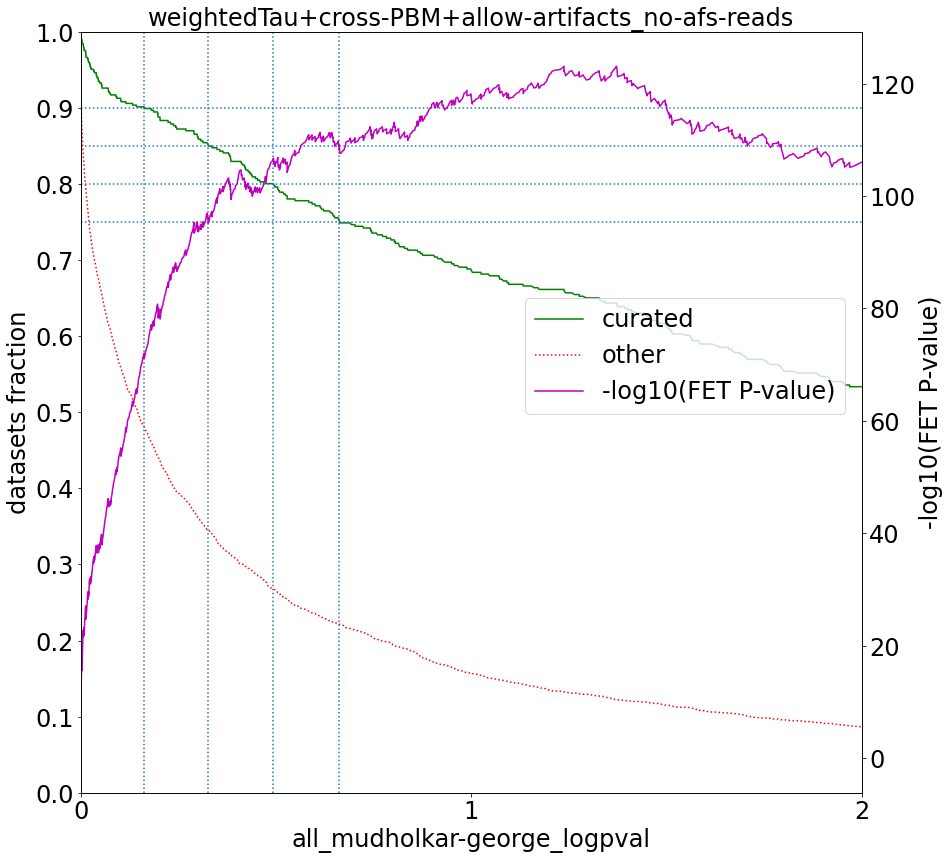

<Figure size 1008x1008 with 0 Axes>

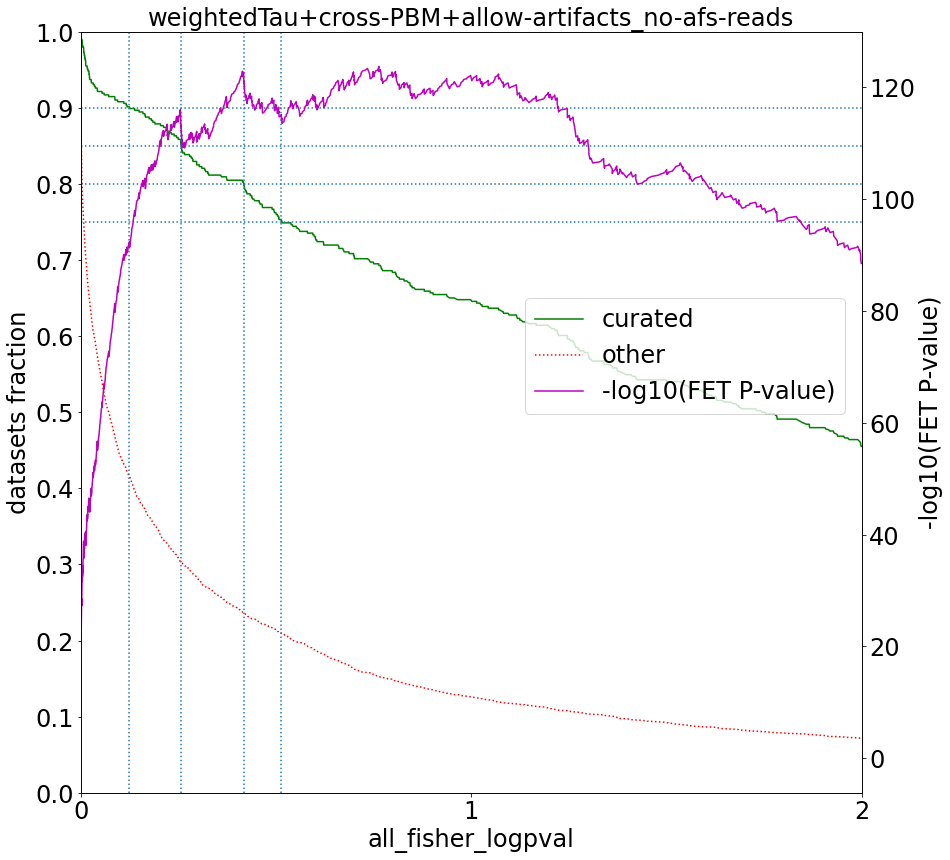

In [22]:
for feature in ['all_mudholkar-george_logpval', 'all_fisher_logpval']:
    y_full = (df['is_curated'] == 'Curated').astype(int)

    X_full = df[ [feature] ]
#     X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.33, random_state=42)

    imputer = SimpleImputer(strategy='median')
#     imputer.fit(X_train)
#     X_full = imputer.transform(X_full)
#     X_train = imputer.transform(X_train)
#     X_test = imputer.transform(X_test)
    X_full = imputer.fit_transform(X_full)

#     classifier = LogisticRegression(random_state=42, penalty='l2', solver='liblinear', class_weight='balanced').fit(X_train, y_train)

#     y_full_predictions = classifier.predict_proba(X_full)[:, 1]
    y_full_predictions = df[feature]
    #     y_test_predictions = classifier.predict_proba(X_test)[:, 1]
    #     y_test_predictions_binary = classifier.predict(X_test)

    #     plt.figure()
    #     clf_name = classifier_name([feature])
    #     PrecisionRecallDisplay.from_predictions(y_test, y_test_predictions, name=clf_name, pos_label=1)
    #     plt.savefig(f'{results_folder}/PR_{clf_name}.png')
    #     plt.close()

    # print('\n'.join(str(arr) for arr in zip(list(X.columns), classifier.coef_[0])))
    # print(f'--------------------\n{feature}')
    # print('classifier score:', classifier.score(X_test, y_test))
    # print('balanced accuracy:', balanced_accuracy_score(y_test, y_test_predictions_binary))

    # for (recall_threshold, score, (pos_recalled, pos_total), (neg_recalled, neg_total)) in prediction_rates_by_recall(y_full, y_full_predictions, [0.75, 0.9, 0.95]):
    #     print(f'At recall {pos_recalled / pos_total} num positives is {pos_recalled} (of {pos_total}), num negatives is {neg_recalled} (of {neg_total})')
    # # for (recall, precision) in precision_by_recall(y_test, y_test_predictions, [0.75, 0.9, 0.95]):
    # #     print(f'At recall {recall} precision is {precision}', file=fw)
    # # print('mAP:', average_precision_score(y_test, y_test_predictions), file=fw)

    
    recall_thresholds = [0.9, 0.85, 0.8, 0.75]
    
    with open(f'{results_folder}/datasets_thresholds@{feature}@{heatmap_type_name}.tsv', 'w') as fw:
        print('recall', feature, 'curated_recalled', 'curated_total', 'other_recalled', 'other_total', sep='\t', file=fw)
        for (recall_threshold, score, (pos_recalled, pos_total), (neg_recalled, neg_total)) in prediction_rates_by_recall(y_full, y_full_predictions, recall_thresholds):
            print(recall_threshold, score, pos_recalled, pos_total, neg_recalled, neg_total, sep='\t', file=fw)

    
    curve_score = []
    curve_pos_count = []
    curve_neg_count = []
    curve_pos_rate = []
    curve_neg_rate = []
    fet_logpvals = []
    for (score, (pos_recalled, pos_total), (neg_recalled, neg_total)) in positive_negative_curve(y_full, y_full_predictions):
        curve_score.append(score)
        curve_pos_count.append(pos_recalled)
        curve_neg_count.append(neg_recalled)
        curve_pos_rate.append(pos_recalled / pos_total)
        curve_neg_rate.append(neg_recalled / neg_total)
        fet = scipy.stats.fisher_exact([[pos_recalled, pos_total - pos_recalled], [neg_recalled, neg_total - neg_recalled]], alternative='greater')[1]
        fet_logpvals.append(-math.log10(fet))
        # print(f'At recall {pos_recalled / pos_total} num positives is {pos_recalled} (of {pos_total}), num negatives is {neg_recalled} (of {neg_total})')


    #     plt.figure()
    #     plt.plot(curve_score, [(p / n if n != 0 else 0) for p,n in zip(curve_pos_rate, curve_neg_rate)], '-g', label = 'curated rate / other rate')
    #     plt.xlabel('score')
    #     plt.ylabel('ratio of fractions')
    #     plt.legend()
    #     plt.show()
    #     plt.close()
        

    plt.figure()
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(curve_score, curve_pos_rate, '-g', label = 'curated')
    ax1.plot(curve_score, curve_neg_rate, ':r', label = 'other')
    
    for recall in recall_thresholds:
        ax1.axhline(y=recall, linestyle=':')
    for recall, precision, score in precision_by_recall(y_full, y_full_predictions, recall_thresholds):
        ax2.axvline(x=score, linestyle=':')
        
    ax1.set_xlabel(feature)
    ax1.set_ylabel('datasets fraction')
    ax1.set_yticks(np.arange(0, 1.001,step=0.1))
    ax1.set_xticks(np.arange(0, 16.01,step=1))
    ax1.set_ylim(0, 1)
    ax2.set_ylabel('-log10(FET P-value)')
    ax2.plot(curve_score, fet_logpvals, '-m', label = '-log10(FET P-value)')
    fig.legend(loc='center right', bbox_to_anchor=(0.85,0.5))
    plt.title(heatmap_type_name)
    ax1.set_xlim(0, 16)
    plt.savefig(f'{results_folder}/datasets_fraction@{feature}@{heatmap_type_name}@full.png')
    ax1.set_xlim(0, 2)
    plt.savefig(f'{results_folder}/datasets_fraction@{feature}@{heatmap_type_name}@short.png')
    


<Figure size 1008x1008 with 0 Axes>

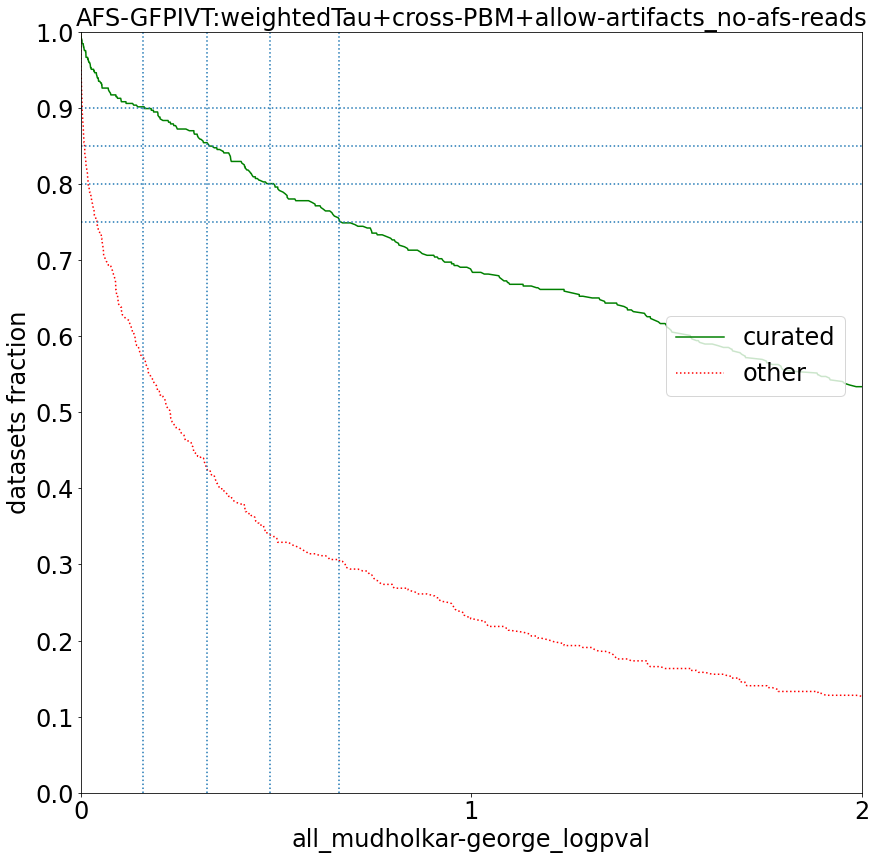

<Figure size 1008x1008 with 0 Axes>

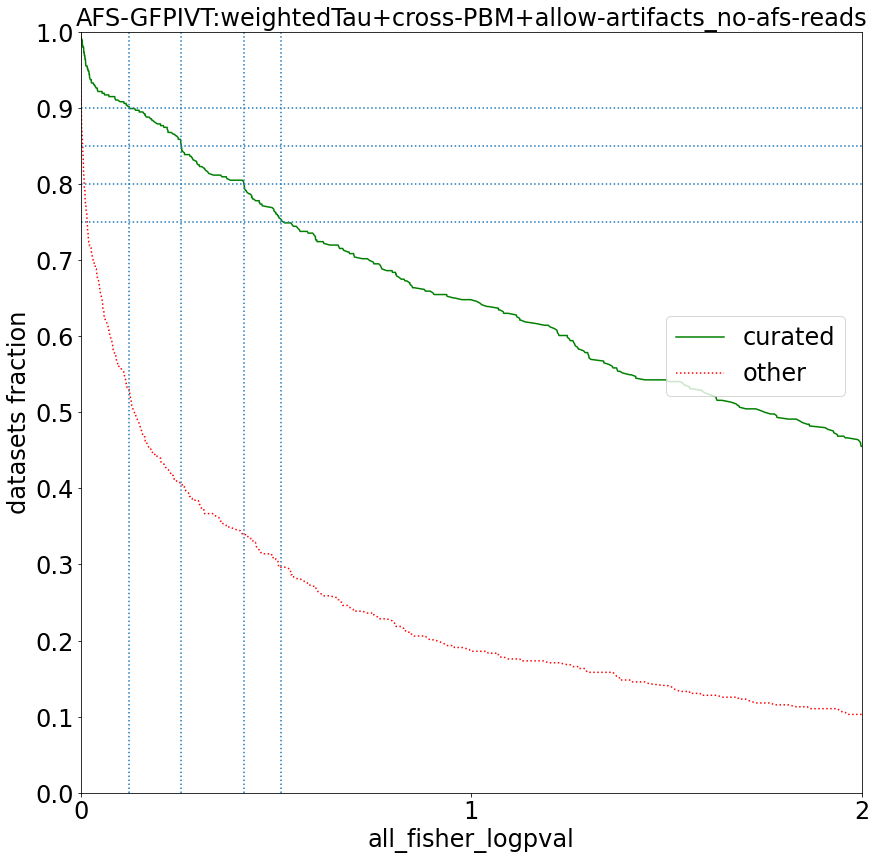

<Figure size 1008x1008 with 0 Axes>

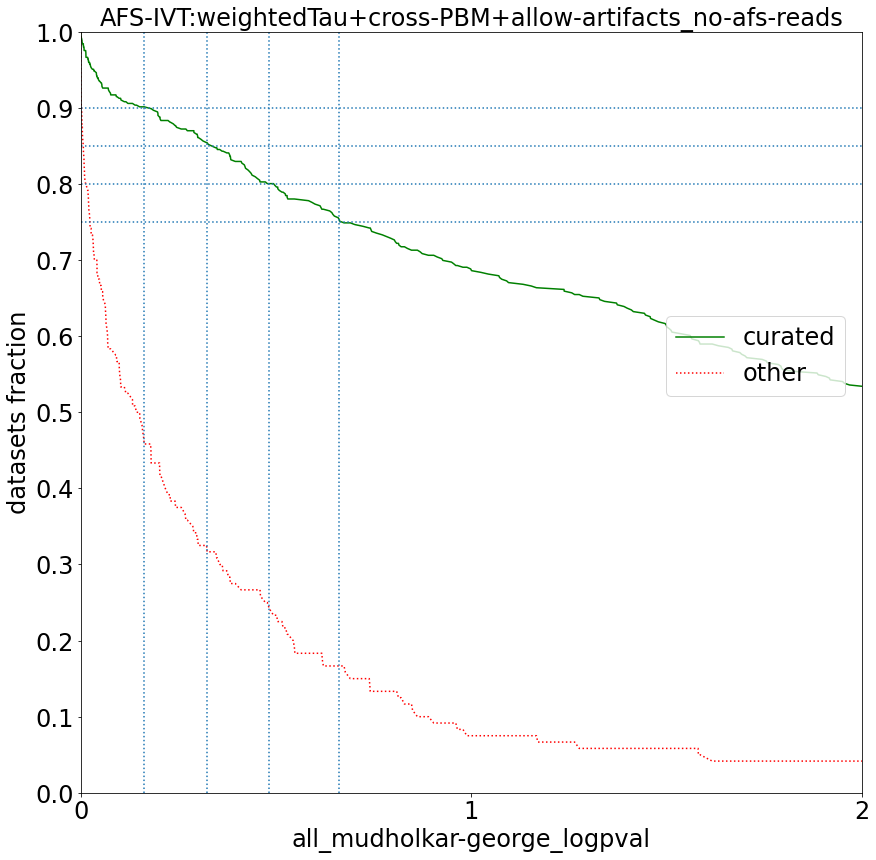

<Figure size 1008x1008 with 0 Axes>

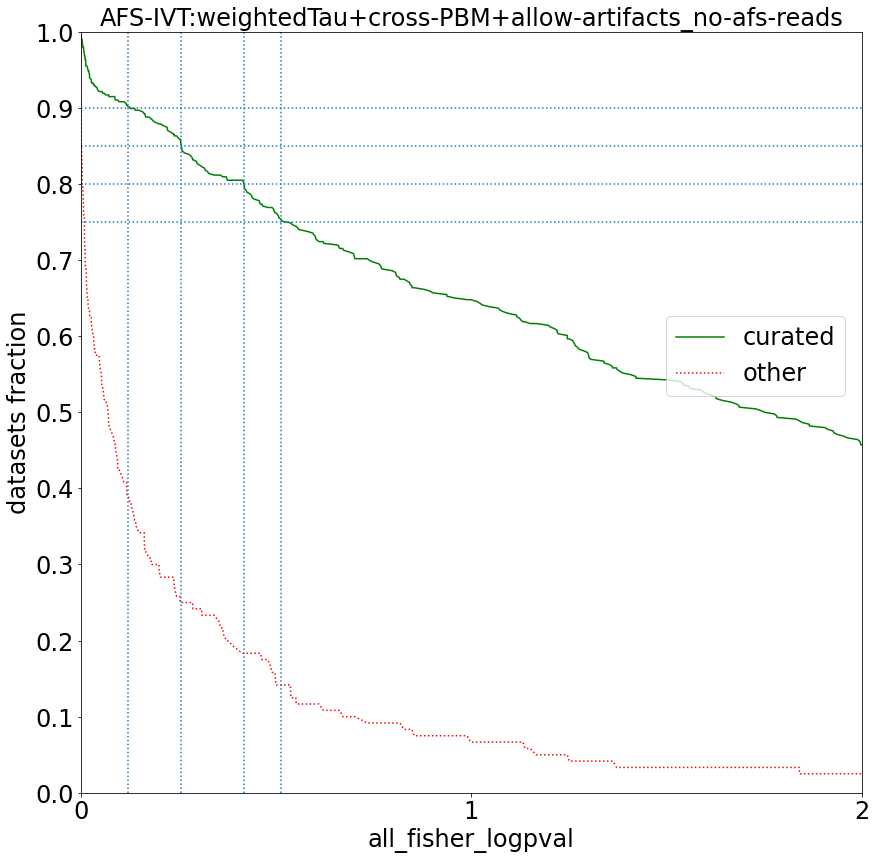

<Figure size 1008x1008 with 0 Axes>

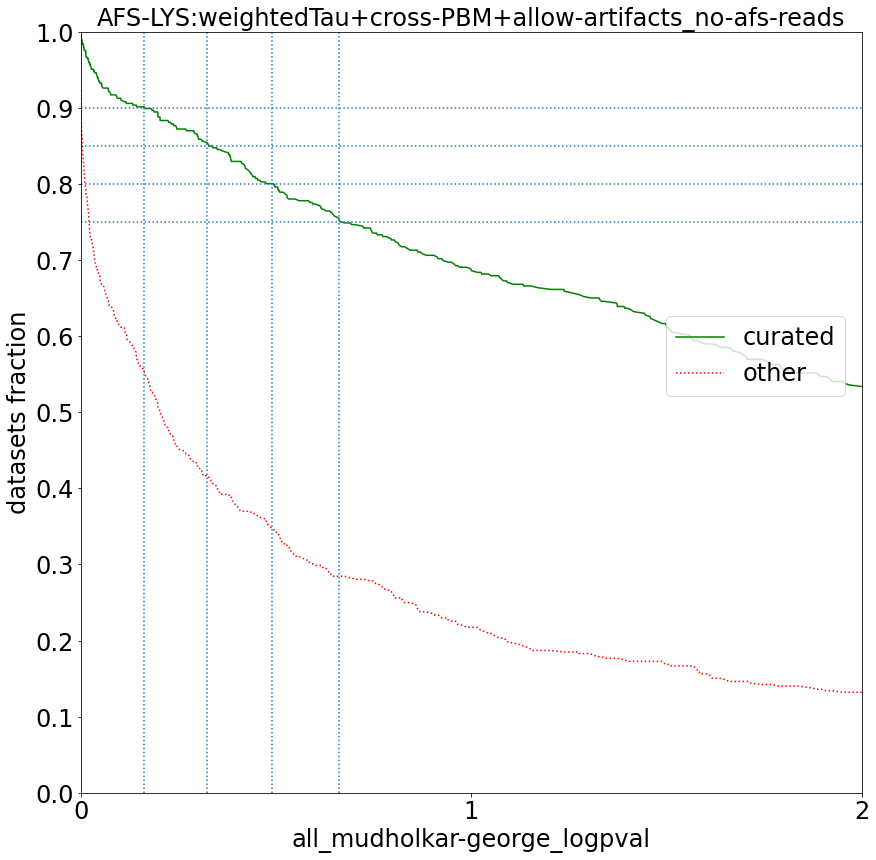

<Figure size 1008x1008 with 0 Axes>

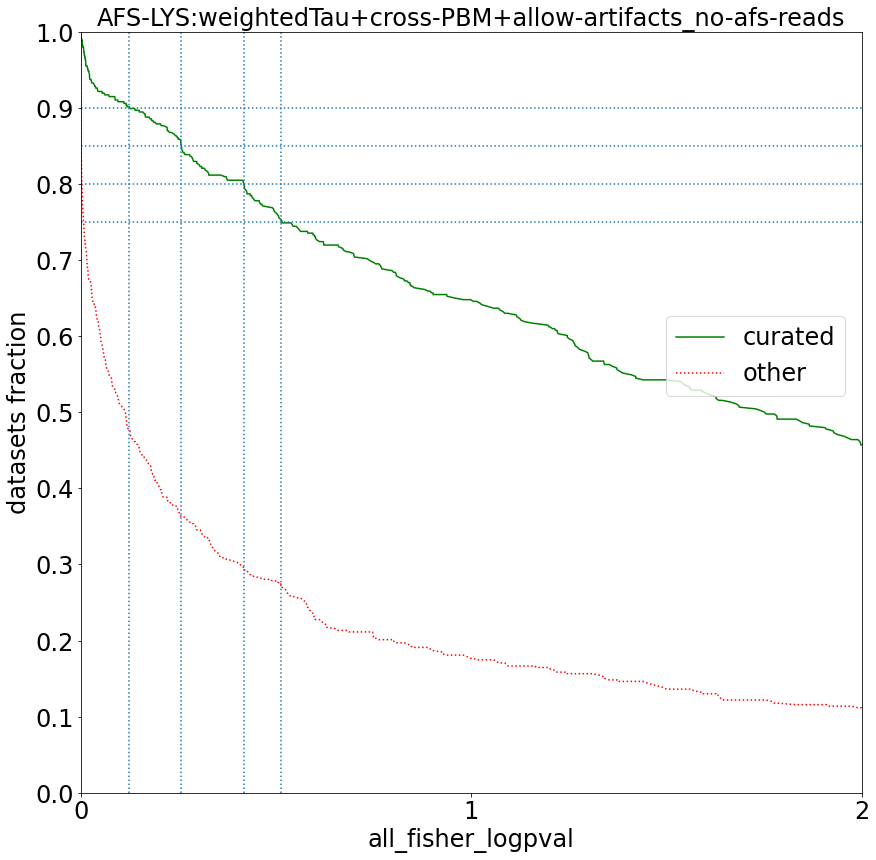

<Figure size 1008x1008 with 0 Axes>

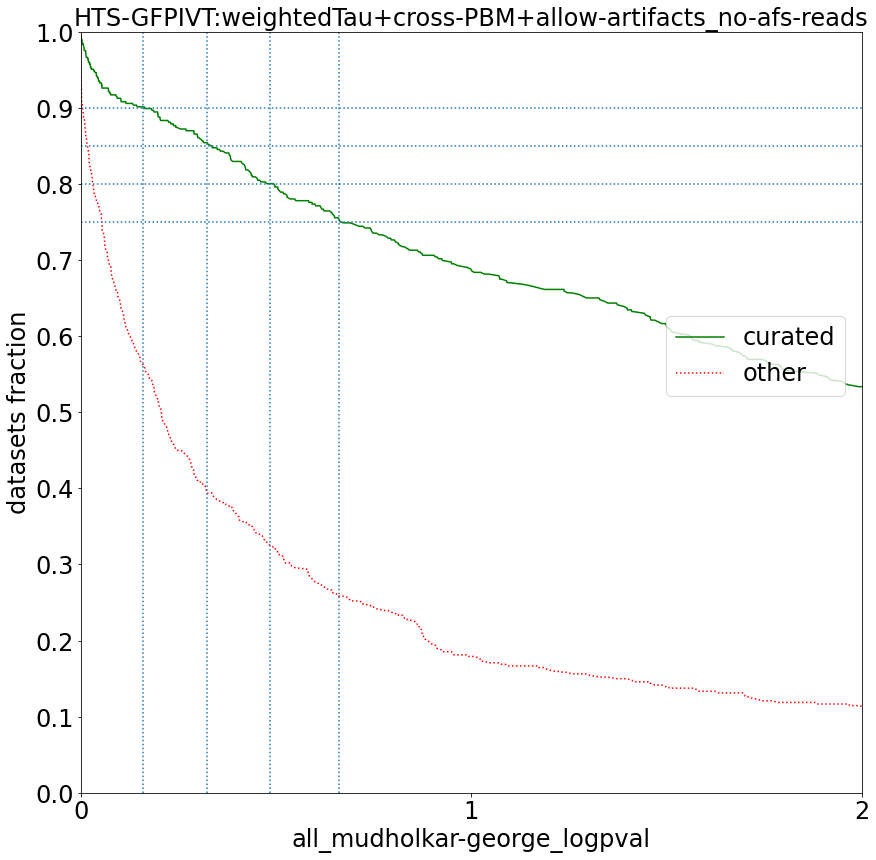

<Figure size 1008x1008 with 0 Axes>

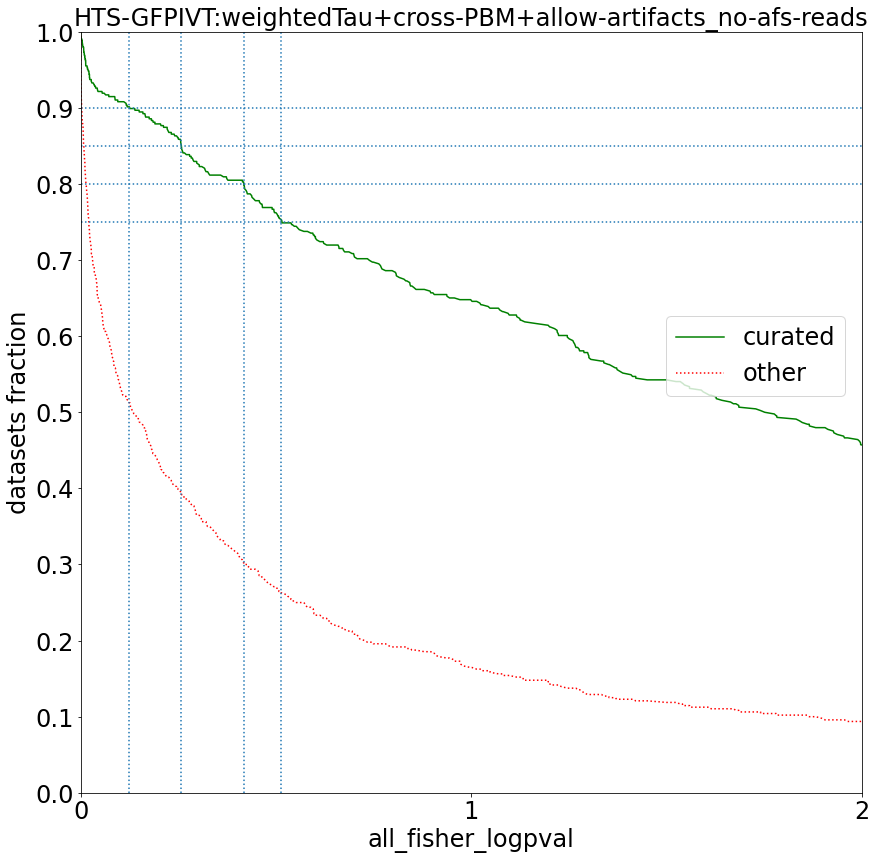

<Figure size 1008x1008 with 0 Axes>

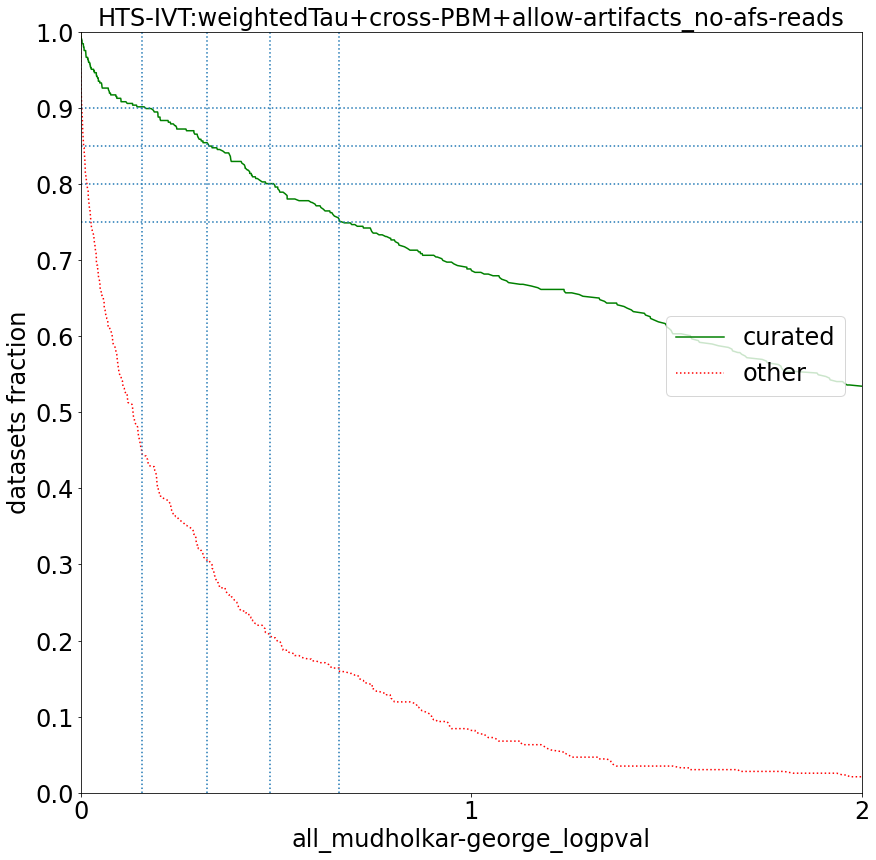

<Figure size 1008x1008 with 0 Axes>

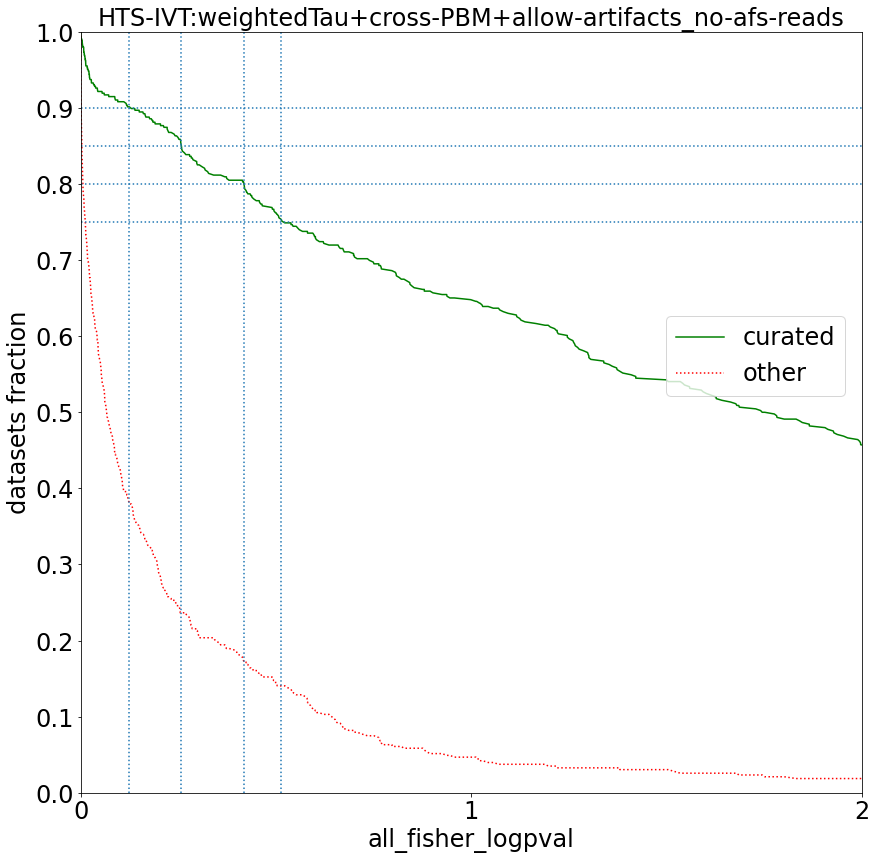

<Figure size 1008x1008 with 0 Axes>

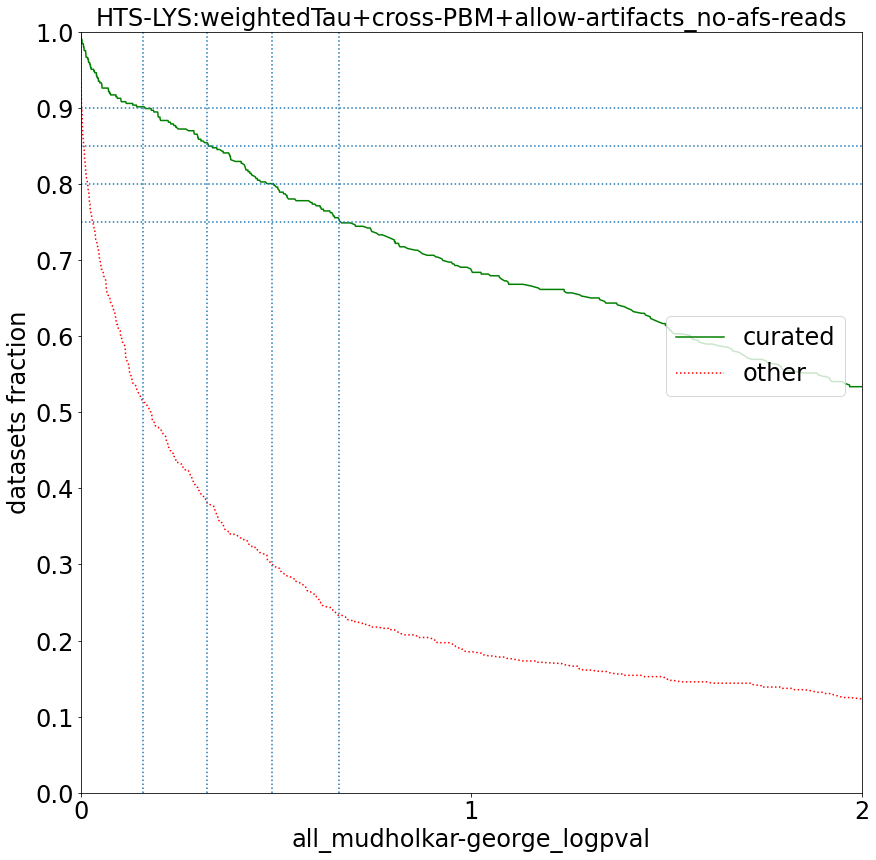

<Figure size 1008x1008 with 0 Axes>

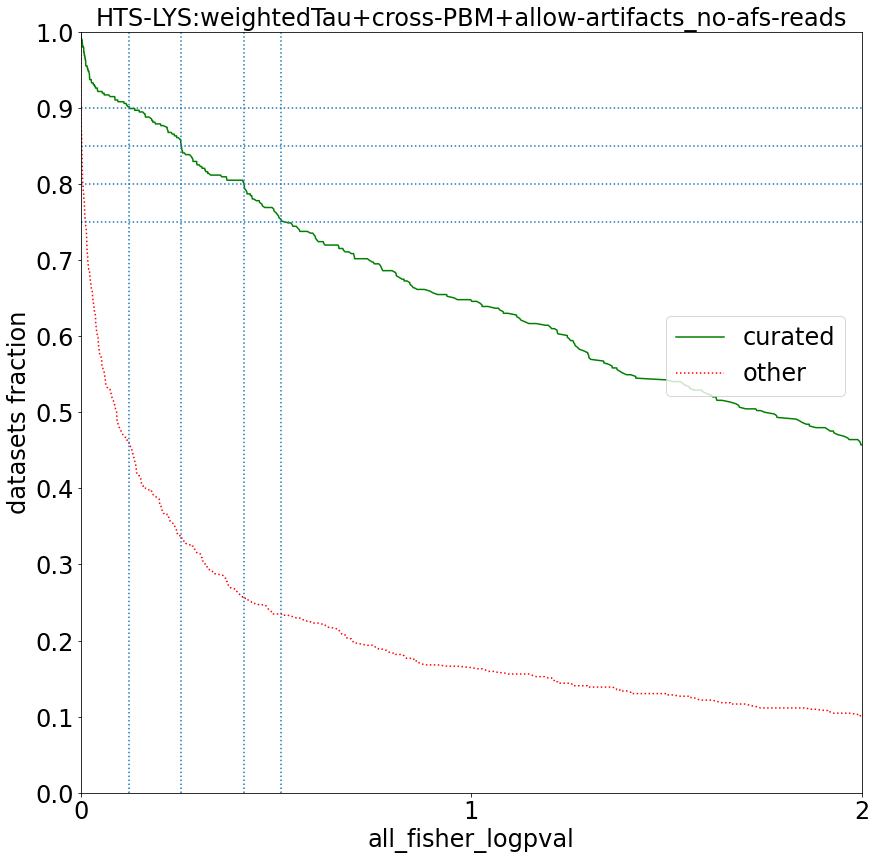

<Figure size 1008x1008 with 0 Axes>

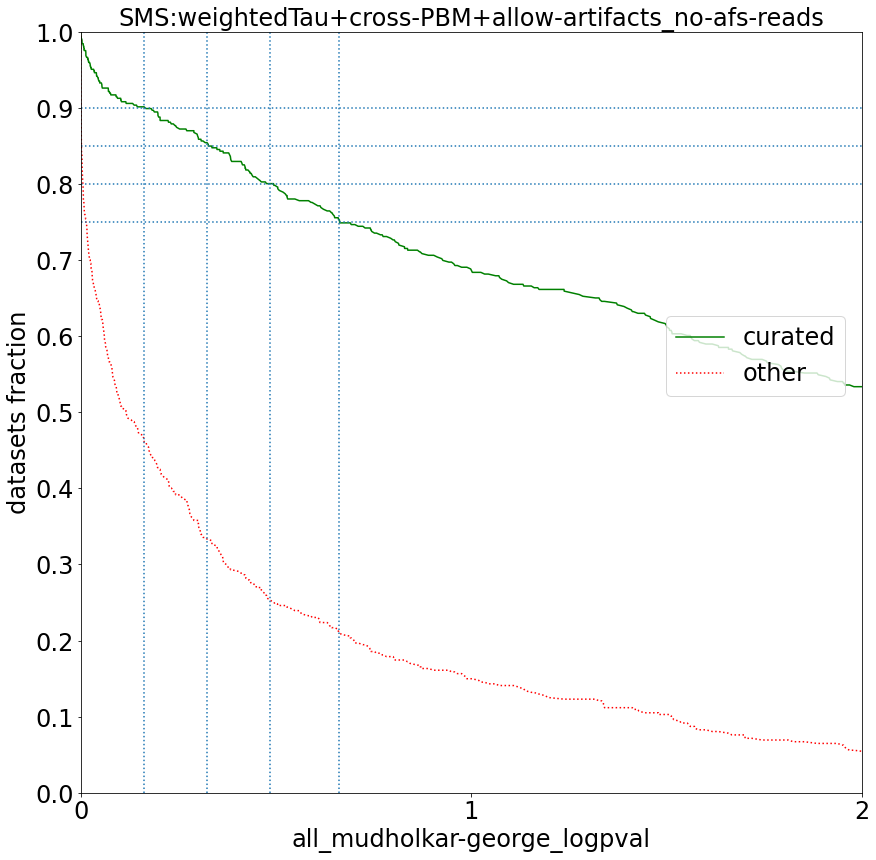

<Figure size 1008x1008 with 0 Axes>

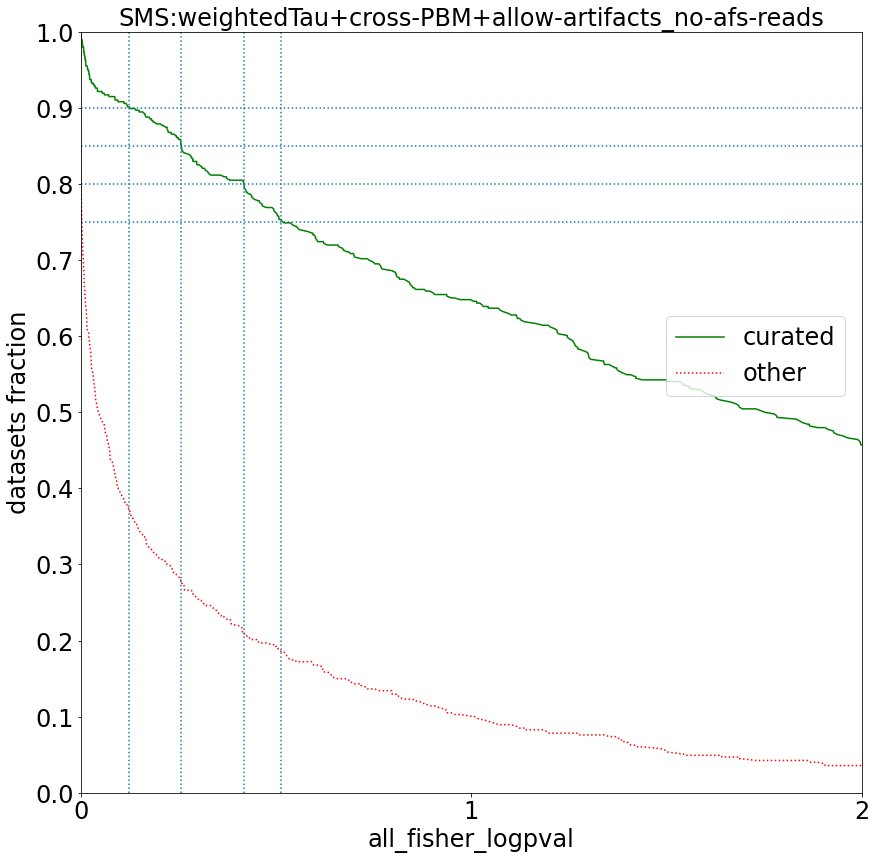

<Figure size 1008x1008 with 0 Axes>

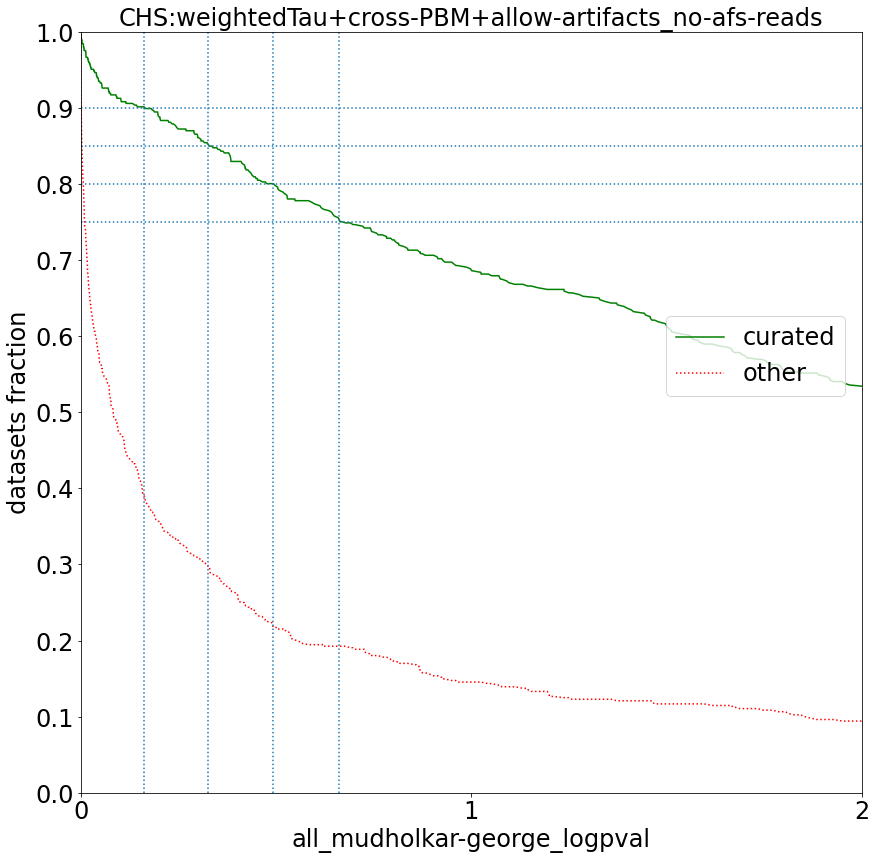

<Figure size 1008x1008 with 0 Axes>

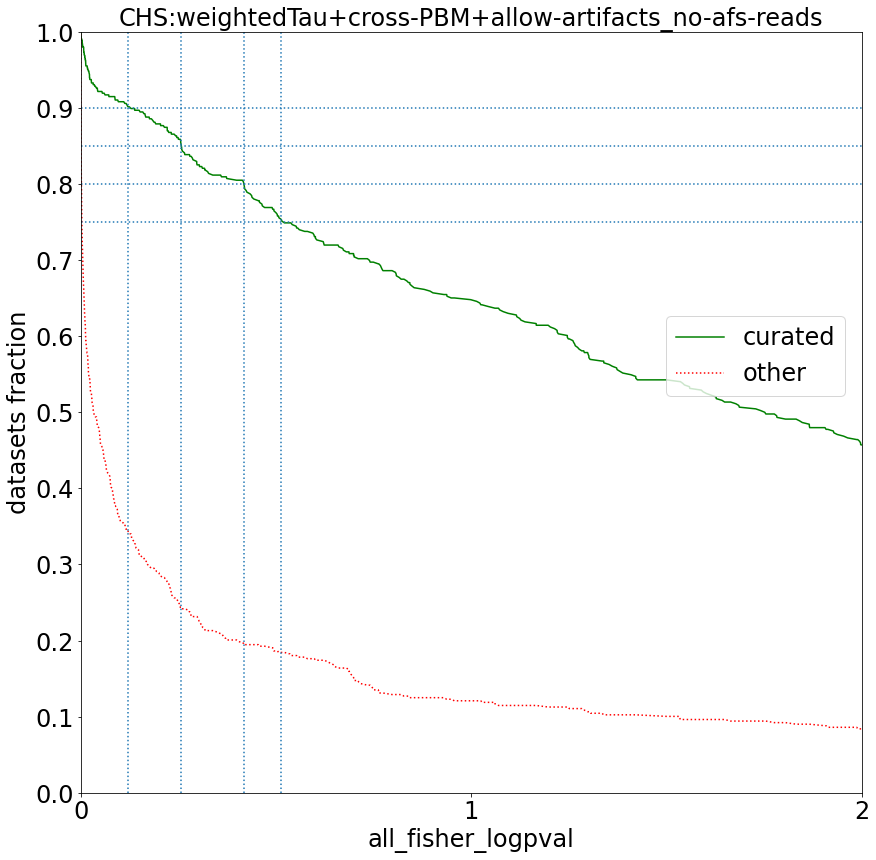

<Figure size 1008x1008 with 0 Axes>

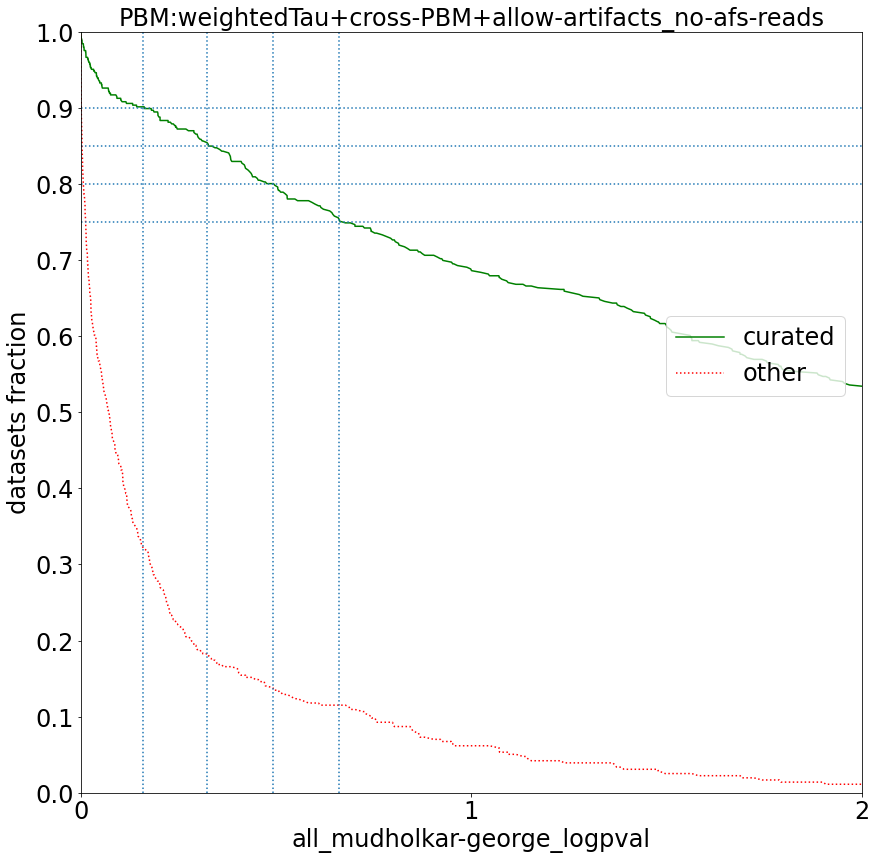

<Figure size 1008x1008 with 0 Axes>

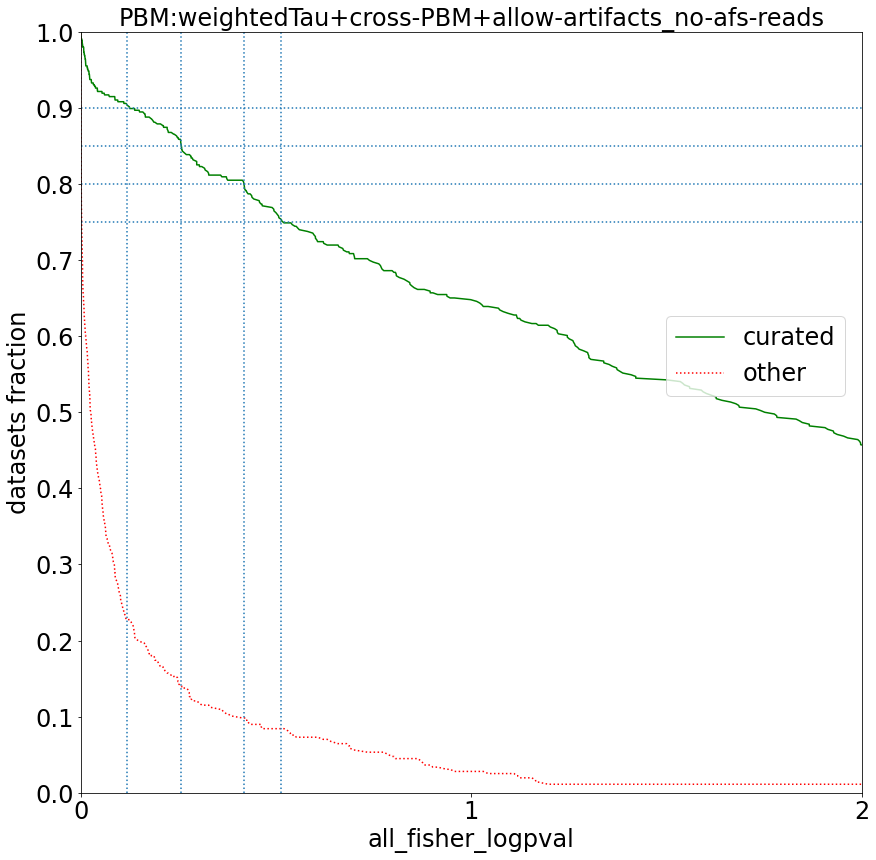

In [23]:
for exp_type in df.experiment_type.unique():
    df_datatype = df[(df.is_curated == 'Curated') | ((df.is_curated == 'Non-curated') & (df.experiment_type == exp_type))]
    for feature in ['all_mudholkar-george_logpval', 'all_fisher_logpval']:
        y_full = (df_datatype['is_curated'] == 'Curated').astype(int)
        X_full = df_datatype[ [feature] ]
        imputer = SimpleImputer(strategy='median')
        X_full = imputer.fit_transform(X_full)
        y_full_predictions = df_datatype[feature]

        recall_thresholds = [0.9, 0.85, 0.8, 0.75]

        with open(f'{results_folder}/datasets_thresholds@{feature}@{heatmap_type_name}@{exp_type}.tsv', 'w') as fw:
            print('recall', feature, 'curated_recalled', 'curated_total', 'other_recalled', 'other_total', sep='\t', file=fw)
            for (recall_threshold, score, (pos_recalled, pos_total), (neg_recalled, neg_total)) in prediction_rates_by_recall(y_full, y_full_predictions, recall_thresholds):
                print(recall_threshold, score, pos_recalled, pos_total, neg_recalled, neg_total, sep='\t', file=fw)


        curve_score = []
        curve_pos_count = []
        curve_neg_count = []
        curve_pos_rate = []
        curve_neg_rate = []
        fet_logpvals = []
        for (score, (pos_recalled, pos_total), (neg_recalled, neg_total)) in positive_negative_curve(y_full, y_full_predictions):
            curve_score.append(score)
            curve_pos_count.append(pos_recalled)
            curve_neg_count.append(neg_recalled)
            curve_pos_rate.append(pos_recalled / pos_total)
            curve_neg_rate.append(neg_recalled / neg_total)
            fet = scipy.stats.fisher_exact([[pos_recalled, pos_total - pos_recalled], [neg_recalled, neg_total - neg_recalled]], alternative='greater')[1]
            fet_logpvals.append(-math.log10(fet))


        plt.figure()
        fig, ax1 = plt.subplots()
    #     ax2 = ax1.twinx()
        ax1.plot(curve_score, curve_pos_rate, '-g', label = 'curated')
        ax1.plot(curve_score, curve_neg_rate, ':r', label = 'other')

        for recall in recall_thresholds:
            ax1.axhline(y=recall, linestyle=':')
        for recall, precision, score in precision_by_recall(y_full, y_full_predictions, recall_thresholds):
            ax1.axvline(x=score, linestyle=':')

        ax1.set_xlabel(feature)
        ax1.set_ylabel('datasets fraction')
        ax1.set_yticks(np.arange(0, 1.001,step=0.1))
        ax1.set_xticks(np.arange(0, 16.01,step=1))
        ax1.set_ylim(0, 1)
    #     ax2.set_ylabel('-log10(FET P-value)')
    #     ax2.plot(curve_score, fet_logpvals, '-m', label = '-log10(FET P-value)')
        fig.legend(loc='center right', bbox_to_anchor=(0.85,0.5))
        plt.title(f'{exp_type}:{heatmap_type_name}')
        ax1.set_xlim(0, 16)
        plt.savefig(f'{results_folder}/datasets_fraction@{feature}@{heatmap_type_name}@full@{exp_type}.png')
        ax1.set_xlim(0, 2)
        plt.savefig(f'{results_folder}/datasets_fraction@{feature}@{heatmap_type_name}@short@{exp_type}.png')

